# TEST DIFFERENT INTERPOLATION METHODS


Transform data to CLR to work on ratios and not counts.

Anlayse different interpolation methods, analyse and visualize the results. 

1. To test interpolation methods I mask 10% of timepoints and interpolated them using one of interpolation methods:
- LINEAR
- CUBIC
- QUADRATIC
- NEAREST
- PCHIP
- BSPLINE of degree 1
- BSPLINE of degree 2
- BSPLINE of degree 3

Each interpolation is performed 50 times with different 10% points masked each time

2. Then, I analyse the results using:
- Mantel test between true and interpolated datapoins (Bray Curtis distance matrices)
- Bray Curtis distance between true and interpolated data
- RMSE for each timepoint
- RMSE for each features

Mantel test and BC will be also calculated between interpolated and previous or next day to verify how much the interpolation uses closest points 


3. Next, I plot lineplots between true and interpolated data (median counts per timestep)

In [ ]:
from skbio.stats.composition import clr
import pandas as pd
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import skbio
from skbio.stats.distance import mantel
from skbio.diversity import alpha
from scipy import interpolate, stats
from scipy.spatial import distance
from scipy.interpolate import pchip_interpolate, BSpline, splev
from scipy.spatial.distance import pdist, squareform

from sklearn.metrics import pairwise_distances
from sklearn.metrics import mean_squared_error

In [2]:
sns.set_style('whitegrid')

In [246]:
PATH = 'assigned_sample_names_data/'
FILE = 'female_assigned_sample_names.csv'

DF = pd.read_csv(PATH+FILE, index_col=[0])

# add pseudocount
DF = DF + 1e-2

# transform using clr 
CLR_DF = pd.DataFrame(clr(DF), columns=DF.columns)
CLR_DF.index = DF.index

### INTERPOLATE

In [12]:
#linear interpolation
def linear_interpolation(col, masked_df):
    
    df_interpolated = pd.DataFrame(index = masked_df.index)

    tmp = masked_df[col]
    base_nodes =  tmp.dropna().index #wezlowe
    interpolated_nodes = tmp[tmp.isna()].index #to uzupelniamy
    
    f = interpolate.interp1d(base_nodes,
                             tmp.dropna().values,
                             kind='linear')
    
    new_y = f(interpolated_nodes)
    
    name = str(col)
    df_interpolated.loc[base_nodes, name] = tmp.dropna().values
    df_interpolated.loc[interpolated_nodes, name] = new_y
    
    return df_interpolated

In [13]:
def cubic_interpolation(col, masked_df):
    
    df_interpolated = pd.DataFrame(index = masked_df.index)

    tmp = masked_df[col]
    base_nodes =  tmp.dropna().index #wezlowe
    interpolated_nodes = tmp[tmp.isna()].index #to uzupelniamy
    
    f = interpolate.interp1d(base_nodes,
                             tmp.dropna().values,
                             kind='cubic')
    new_y = f(interpolated_nodes)

    name = str(col)
    df_interpolated.loc[base_nodes, name] = tmp.dropna().values
    df_interpolated.loc[interpolated_nodes, name] = new_y
    
    return df_interpolated

In [14]:
def quardatic_interpolation(col, masked_df):
    
    df_interpolated = pd.DataFrame(index = masked_df.index)

    tmp = masked_df[col]
    base_nodes =  tmp.dropna().index #wezlowe
    interpolated_nodes = tmp[tmp.isna()].index #to uzupelniamy
    
    f = interpolate.interp1d(base_nodes,
                             tmp.dropna().values,
                             kind='quadratic')
    new_y = f(interpolated_nodes)

    name = str(col)
    df_interpolated.loc[base_nodes, name] = tmp.dropna().values
    df_interpolated.loc[interpolated_nodes, name] = new_y
    
    return df_interpolated

In [15]:
def nearest_interpolation(col, masked_df):
    
    df_interpolated = pd.DataFrame(index = masked_df.index)

    tmp = masked_df[col]
    base_nodes =  tmp.dropna().index #wezlowe
    interpolated_nodes = tmp[tmp.isna()].index #to uzupelniamy
    
    f = interpolate.interp1d(base_nodes,
                             tmp.dropna().values,
                             kind='nearest')
    new_y = f(interpolated_nodes)

    name = str(col)
    df_interpolated.loc[base_nodes, name] = tmp.dropna().values
    df_interpolated.loc[interpolated_nodes, name] = new_y
    
    return df_interpolated

In [16]:
def pchip_interpolation(col, masked_df):
    
    df_interpolated = pd.DataFrame(index = masked_df.index)
    
    tmp = masked_df[col]
    base_nodes =  tmp.dropna().index #wezlowe
    interpolated_nodes = tmp[tmp.isna()].index #to uzupelniamy

    y = pchip_interpolate(base_nodes,
                          tmp.dropna().values,
                          interpolated_nodes)
    
    
    name = str(col)
    df_interpolated.loc[base_nodes, name] = tmp.dropna().values
    df_interpolated.loc[interpolated_nodes, name] = y
    
    return df_interpolated

In [17]:
def bspline_interpolation(col, masked_df, degree=1):
    
    df_interpolated = pd.DataFrame(index = masked_df.index)

    tmp = masked_df[col]
    base_nodes =  tmp.dropna().index #wezlowe
    interpolated_nodes = tmp[tmp.isna()].index #to uzupelniamy
    
    f = BSpline(base_nodes,tmp.dropna().values, degree)
    new_y = f(interpolated_nodes)

    name = str(col)
    df_interpolated.loc[base_nodes, name] = tmp.dropna().values
    df_interpolated.loc[interpolated_nodes, name] = new_y
    
    return df_interpolated

In [18]:
def apply_interpolation(df, interpolation_function):
    
    INTERPOLATED_COLUMNS = []
    for col in df.columns:
        interpolated_col = interpolation_function(col, df)
        INTERPOLATED_COLUMNS.append(interpolated_col)
    INTERPOLATED_DF = pd.concat(INTERPOLATED_COLUMNS, axis=1)
    
    return INTERPOLATED_DF


def apply_bspline_interpolation(df, interpolation_function, degree=1):
    
    INTERPOLATED_COLUMNS = []
    for col in df.columns:
        interpolated_col = interpolation_function(col, df, degree)
        INTERPOLATED_COLUMNS.append(interpolated_col)
    INTERPOLATED_DF = pd.concat(INTERPOLATED_COLUMNS, axis=1)
    
    return INTERPOLATED_DF

In [108]:
def calculate_mantel_test(true_df, interpolated_df, metric):
    
    TRUE_DISTANCE_MATRIX = squareform(pdist(true_df, metric = metric))
    INTERPOLATED_DISTANCE_MATRIX = squareform(pdist(interpolated_df, metric = metric))

    corr = mantel(TRUE_DISTANCE_MATRIX, INTERPOLATED_DISTANCE_MATRIX)[0]
    
    return corr

def calculate_braycurtis(true, test):
    
    BC = []
    for i in true.index.tolist():

        bc = distance.braycurtis(true.loc[i], test.loc[i])
        BC.append(bc)

    MEAN_BC = np.mean(BC)
    
    return MEAN_BC

In [13]:
def calculate_interpolation_similarity(true_data, interpolated_dfs, interpolation_names):
    
    MANTEL = []
    BC = []
    SPEARMAN = []
    PEARSON = []

    for interpolated_df in interpolated_dfs:
        mantel_rho = calculate_mantel_test(true_data, interpolated_df, 'braycurtis')
        bc_distance = calculate_braycurtis(true_data, interpolated_df)
        spearman_corr, pearson_corr = calculate_correlation(true_data, interpolated_df)

        MANTEL.append(mantel_rho)
        BC.append(bc_distance)
        SPEARMAN.append(spearman_corr)
        PEARSON.append(pearson_corr)

    MANTEL_DF = pd.DataFrame(list(zip(interpolation_names, MANTEL)), columns = ['INTERPOLATION', 'MANTEL_RHO'])
    BC_DF = pd.DataFrame(list(zip(interpolation_names, BC)), columns = ['INTERPOLATION', 'BC'])


    return MANTEL_DF, BC_DF

In [14]:
def interpolation_experiment_true(data):
    
    data = data.reset_index(drop=True)
    n = np.int(data.shape[0] * 0.1)
    INDEX_TO_MASK = random.sample(data.iloc[5:-5].index.tolist(), n)
    INDEX_TO_MASK.sort()

    data_masked = data.copy()
    data_masked.loc[INDEX_TO_MASK] = np.nan

    LINEAR_INTERPOLATION = apply_interpolation(data_masked, linear_interpolation).loc[INDEX_TO_MASK].reset_index(drop=True)
    CUBIC_INTERPOLATION = apply_interpolation(data_masked, cubic_interpolation).loc[INDEX_TO_MASK].reset_index(drop=True)
    QUADRATIC_INTERPOLATION = apply_interpolation(data_masked, quardatic_interpolation).loc[INDEX_TO_MASK].reset_index(drop=True)
    NEAREST_INTERPOLATION = apply_interpolation(data_masked, nearest_interpolation).loc[INDEX_TO_MASK].reset_index(drop=True)
    PCHIP_INTERPOLATION = apply_interpolation(data_masked, pchip_interpolation).loc[INDEX_TO_MASK].reset_index(drop=True)
    BSPLINE_D1_INTERPOLATION = apply_bspline_interpolation(data_masked, bspline_interpolation, 1).loc[INDEX_TO_MASK].reset_index(drop=True)
    BSPLINE_D2_INTERPOLATION = apply_bspline_interpolation(data_masked, bspline_interpolation, 2).loc[INDEX_TO_MASK].reset_index(drop=True)
    BSPLINE_D3_INTERPOLATION = apply_bspline_interpolation(data_masked, bspline_interpolation, 3).loc[INDEX_TO_MASK].reset_index(drop=True)
    
    INTERPOLATED_DFS = [LINEAR_INTERPOLATION,
                        CUBIC_INTERPOLATION,
                        QUADRATIC_INTERPOLATION,
                        NEAREST_INTERPOLATION,
                        PCHIP_INTERPOLATION,
                        BSPLINE_D1_INTERPOLATION,
                        BSPLINE_D2_INTERPOLATION,
                        BSPLINE_D3_INTERPOLATION
                       ]
    
    INTERPOLATION_NAMES = ['LINEAR',
                           'CUBIC',
                           'QUADRATIC',
                           'NEAREST',
                           'PCHIP',
                           'BSPLINE_D1',
                           'BSPLINE_D2',
                           'BSPLINE_D3'
                          ]
    
    TRUE_DATA = data.loc[INDEX_TO_MASK].reset_index(drop=True)
    
    MANTEL_DF, BC_DF = calculate_interpolation_similarity(TRUE_DATA, INTERPOLATED_DFS, INTERPOLATION_NAMES)
    
    return MANTEL_DF, BC_DF

In [15]:
def interpolation_experiment_previous(data):
        
    data = data.reset_index(drop=True)
    n = np.int(data.shape[0] * 0.1)
    INDEX_TO_MASK = random.sample(data.iloc[5:-5].index.tolist(), n)
    INDEX_TO_MASK.sort()

    data_masked = data.copy()
    data_masked.loc[INDEX_TO_MASK] = np.nan

    LINEAR_INTERPOLATION = apply_interpolation(data_masked, linear_interpolation).loc[INDEX_TO_MASK].reset_index(drop=True)
    CUBIC_INTERPOLATION = apply_interpolation(data_masked, cubic_interpolation).loc[INDEX_TO_MASK].reset_index(drop=True)
    QUADRATIC_INTERPOLATION = apply_interpolation(data_masked, quardatic_interpolation).loc[INDEX_TO_MASK].reset_index(drop=True)
    NEAREST_INTERPOLATION = apply_interpolation(data_masked, nearest_interpolation).loc[INDEX_TO_MASK].reset_index(drop=True)
    PCHIP_INTERPOLATION = apply_interpolation(data_masked, pchip_interpolation).loc[INDEX_TO_MASK].reset_index(drop=True)
    BSPLINE_D1_INTERPOLATION = apply_bspline_interpolation(data_masked, bspline_interpolation, 1).loc[INDEX_TO_MASK].reset_index(drop=True)
    BSPLINE_D2_INTERPOLATION = apply_bspline_interpolation(data_masked, bspline_interpolation, 2).loc[INDEX_TO_MASK].reset_index(drop=True)
    BSPLINE_D3_INTERPOLATION = apply_bspline_interpolation(data_masked, bspline_interpolation, 3).loc[INDEX_TO_MASK].reset_index(drop=True)
    
    INTERPOLATED_DFS = [LINEAR_INTERPOLATION,
                        CUBIC_INTERPOLATION,
                        QUADRATIC_INTERPOLATION,
                        NEAREST_INTERPOLATION,
                        PCHIP_INTERPOLATION,
                        BSPLINE_D1_INTERPOLATION,
                        BSPLINE_D2_INTERPOLATION,
                        BSPLINE_D3_INTERPOLATION
                       ]
    
    INTERPOLATION_NAMES = ['LINEAR',
                           'CUBIC',
                           'QUADRATIC',
                           'NEAREST',
                           'PCHIP',
                           'BSPLINE_D1',
                           'BSPLINE_D2',
                           'BSPLINE_D3'
                          ]
    
    PREVIOUS_INDEX = [i-1 for i in INDEX_TO_MASK]
    PREVIOUS_DATA = data.loc[PREVIOUS_INDEX].reset_index(drop=True)

    PREVIOUS_MANTEL_DF, PREVIOUS_BC_DF = calculate_interpolation_similarity(PREVIOUS_DATA, INTERPOLATED_DFS, INTERPOLATION_NAMES)
    
    return PREVIOUS_MANTEL_DF, PREVIOUS_BC_DF

In [16]:
def interpolation_experiment_next(data):
    
    data = data.reset_index(drop=True)
    n = np.int(data.shape[0] * 0.1)
    INDEX_TO_MASK = random.sample(data.iloc[5:-5].index.tolist(), n)
    INDEX_TO_MASK.sort()

    data_masked = data.copy()
    data_masked.loc[INDEX_TO_MASK] = np.nan

    LINEAR_INTERPOLATION = apply_interpolation(data_masked, linear_interpolation).loc[INDEX_TO_MASK].reset_index(drop=True)
    CUBIC_INTERPOLATION = apply_interpolation(data_masked, cubic_interpolation).loc[INDEX_TO_MASK].reset_index(drop=True)
    QUADRATIC_INTERPOLATION = apply_interpolation(data_masked, quardatic_interpolation).loc[INDEX_TO_MASK].reset_index(drop=True)
    NEAREST_INTERPOLATION = apply_interpolation(data_masked, nearest_interpolation).loc[INDEX_TO_MASK].reset_index(drop=True)
    PCHIP_INTERPOLATION = apply_interpolation(data_masked, pchip_interpolation).loc[INDEX_TO_MASK].reset_index(drop=True)
    BSPLINE_D1_INTERPOLATION = apply_bspline_interpolation(data_masked, bspline_interpolation, 1).loc[INDEX_TO_MASK].reset_index(drop=True)
    BSPLINE_D2_INTERPOLATION = apply_bspline_interpolation(data_masked, bspline_interpolation, 2).loc[INDEX_TO_MASK].reset_index(drop=True)
    BSPLINE_D3_INTERPOLATION = apply_bspline_interpolation(data_masked, bspline_interpolation, 3).loc[INDEX_TO_MASK].reset_index(drop=True)
    
    INTERPOLATED_DFS = [LINEAR_INTERPOLATION,
                        CUBIC_INTERPOLATION,
                        QUADRATIC_INTERPOLATION,
                        NEAREST_INTERPOLATION,
                        PCHIP_INTERPOLATION,
                        BSPLINE_D1_INTERPOLATION,
                        BSPLINE_D2_INTERPOLATION,
                        BSPLINE_D3_INTERPOLATION
                       ]
    
    INTERPOLATION_NAMES = ['LINEAR',
                           'CUBIC',
                           'QUADRATIC',
                           'NEAREST',
                           'PCHIP',
                           'BSPLINE_D1',
                           'BSPLINE_D2',
                           'BSPLINE_D3'
                          ]
    
    NEXT_INDEX = [i-1 for i in INDEX_TO_MASK]
    NEXT_DATA = data.loc[NEXT_INDEX].reset_index(drop=True)

    NEXT_MANTEL_DF, NEXT_BC_DF = calculate_interpolation_similarity(NEXT_DATA, INTERPOLATED_DFS, INTERPOLATION_NAMES)
    
    return NEXT_MANTEL_DF, NEXT_BC_DF

In [17]:
def iterate_over_interpolation_results(df, experiment_function):
    
    ITERATION = []
    MANTEL = []
    BC = []

    for i in range(0, 50):
        mantel_df, bc_df, spearman_df, pearson_df = experiment_function(df)
        mantel_df['iteration'] = i
        bc_df['iteration'] = i
        spearman_df['iteration'] = i
        pearson_df['iteration'] = i

        MANTEL.append(mantel_df)
        BC.append(bc_df)
        
    MANTEL = pd.concat(MANTEL)
    BC = pd.concat(BC)

    return MANTEL, BC

In [18]:
MANTEL_true, BC_true = iterate_over_interpolation_results(CLR_DF, interpolation_experiment_true)
MANTEL_previous, BC_previous = iterate_over_interpolation_results(CLR_DF, interpolation_experiment_previous)
MANTEL_next, BC_next = iterate_over_interpolation_results(CLR_DF, interpolation_experiment_next)

In [20]:
MANTEL_true['TARGET'] = 'TRUE'
MANTEL_previous['TARGET'] = 'PREVIOUS'
MANTEL_next['TARGET'] = 'NEXT'
MANTEL_DF = MANTEL_true.append(MANTEL_previous).append(MANTEL_next)

BC_true['TARGET'] = 'TRUE'
BC_previous['TARGET'] = 'PREVIOUS'
BC_next['TARGET'] = 'NEXT'
BC_DF = BC_true.append(BC_previous).append(BC_next)

### ANALYSE INTERPOLATION RESULTS FROM MALE AND FEMALE

In [197]:
def plot_boxplots(df, col):
    
    plt.figure(figsize =(12, 5))
    sns.boxplot(data=df,
                x='INTERPOLATION',
                y=col,
                hue='TARGET',
                linewidth=1.8,
                palette='Set1'
               )
    plt.tight_layout()

In [194]:
mantel_male = pd.read_csv('test_interpolation/results_csv/mantel_male.csv', index_col=[0])
mantel_female = pd.read_csv('test_interpolation/results_csv/mantel_female.csv', index_col=[0])
MANTEL_DF = mantel_male.append(mantel_female).reset_index()

bc_male = pd.read_csv('test_interpolation/results_csv/bc_male.csv', index_col=[0])
bc_female = pd.read_csv('test_interpolation/results_csv/bc_female.csv', index_col=[0])
BC_DF = bc_male.append(bc_female).reset_index()

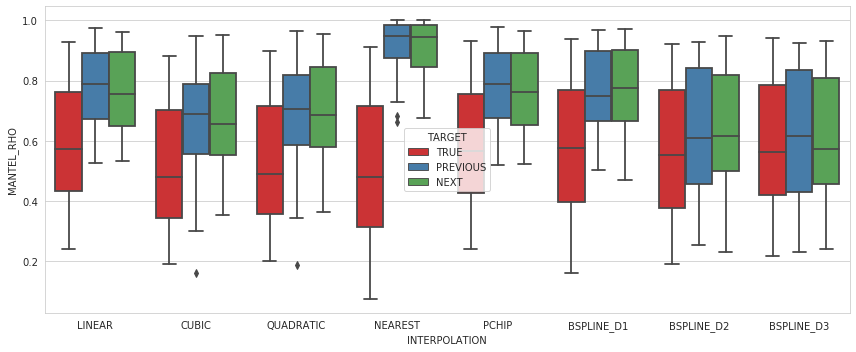

In [200]:
plot_boxplots(MANTEL_DF, 'MANTEL_RHO')

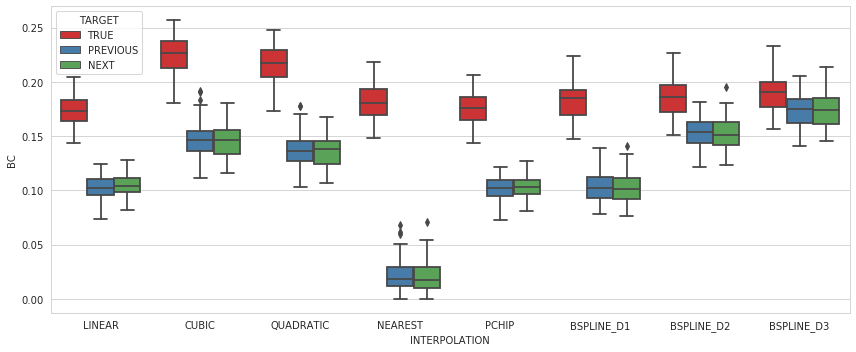

In [201]:
plot_boxplots(BC_DF, 'BC')

### Analyse interpolation without permutation, mask 20% timepoints

In [ ]:
PATH = 'assigned_sample_names_data/'
FILE = 'female_assigned_sample_names.csv'

DF = pd.read_csv(PATH+FILE, index_col=[0])

# add pseudocount
DF = DF + 1e-2

# transform using clr 
CLR_DF = pd.DataFrame(clr(DF), columns=DF.columns)
CLR_DF.index = DF.index

In [206]:
data = CLR_DF.reset_index(drop=True)
n = np.int(data.shape[0] * 0.2)
INDEX_TO_MASK = random.sample(data.iloc[5:-5].index.tolist(), n)
INDEX_TO_MASK.sort()

data_masked = data.copy()
data_masked.loc[INDEX_TO_MASK] = np.nan

In [208]:
true_df = CLR_DF.reset_index(drop=True)

In [209]:
LINEAR_INTERPOLATION = apply_interpolation(data_masked, linear_interpolation)
CUBIC_INTERPOLATION = apply_interpolation(data_masked, cubic_interpolation)
QUADRATIC_INTERPOLATION = apply_interpolation(data_masked, quardatic_interpolation)
NEAREST_INTERPOLATION = apply_interpolation(data_masked, nearest_interpolation)
PCHIP_INTERPOLATION = apply_interpolation(data_masked, pchip_interpolation)
BSPLINE_D1_INTERPOLATION = apply_bspline_interpolation(data_masked, bspline_interpolation, 1)
BSPLINE_D2_INTERPOLATION = apply_bspline_interpolation(data_masked, bspline_interpolation, 2)
BSPLINE_D3_INTERPOLATION = apply_bspline_interpolation(data_masked, bspline_interpolation, 3)

In [210]:
INTERPOLATED_DFS = [LINEAR_INTERPOLATION,
                    CUBIC_INTERPOLATION,
                    QUADRATIC_INTERPOLATION,
                    NEAREST_INTERPOLATION,
                    PCHIP_INTERPOLATION,
                    BSPLINE_D1_INTERPOLATION,
                    BSPLINE_D2_INTERPOLATION,
                    BSPLINE_D3_INTERPOLATION
                   ]

INTERPOLATION_NAMES = ['LINEAR',
                       'CUBIC',
                       'QUADRATIC',
                       'NEAREST',
                       'PCHIP',
                       'BSPLINE_D1',
                       'BSPLINE_D2',
                       'BSPLINE_D3'
                      ]

### RMSE per timestep

In [211]:
def calculate_rmse_timesteps(interpolated_df, masked_index, interpolation_name):
    
    RMSE = []
    for i in INDEX_TO_MASK:

        rmse = mean_squared_error(interpolated_df.iloc[i, :], true_df.iloc[i, :], squared=False)
        RMSE.append(rmse)
        
    RMSE_DF = pd.DataFrame(RMSE, columns=['rmse'])
    RMSE_DF['interpolation'] = interpolation_name
        
    return RMSE_DF

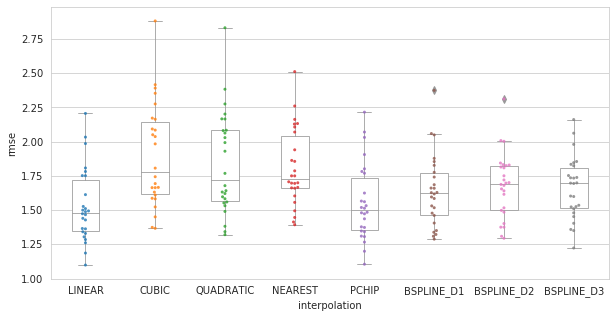

In [212]:
RMSE_STEP = []
for interpolation_df, name in zip(INTERPOLATED_DFS, INTERPOLATION_NAMES):
    df = calculate_rmse_timesteps(interpolation_df, INDEX_TO_MASK, name)        
    RMSE_STEP.append(df)
    
RMSE_STEP = pd.concat(RMSE_STEP)

plt.figure(figsize =(10,5))
sns.boxplot(y = RMSE_STEP['rmse'], x = RMSE_STEP['interpolation'], color='white', linewidth=.8, width=.4)
sns.swarmplot(y = RMSE_STEP['rmse'], x = RMSE_STEP['interpolation'], alpha=.8, s=3)

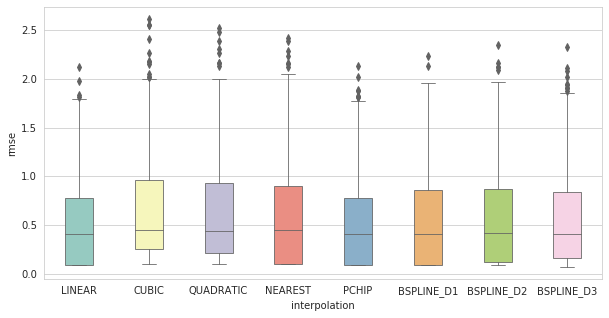

In [213]:
def calculate_rmse_features(true_df, interpolated_df, interpolation_name):
    
    RMSE = []
    for i in range(len(true_df.columns)):

        rmse = mean_squared_error(interpolated_df.iloc[:, i], true_df.iloc[:, i], squared=False)
        RMSE.append(rmse)

    RMSE_DF = pd.DataFrame(RMSE, columns=['rmse'])
    RMSE_DF['interpolation'] = interpolation_name
    
    return RMSE_DF


RMSE_FEATRUES = []
for interpolation_df, name in zip(INTERPOLATED_DFS, INTERPOLATION_NAMES):
    df = calculate_rmse_features(interpolation_df, true_df, name)        
    RMSE_FEATRUES.append(df)
    
RMSE_FEATRUES = pd.concat(RMSE_FEATRUES)


plt.figure(figsize =(10,5))
sns.boxplot(y = RMSE_FEATRUES['rmse'],
            x = RMSE_FEATRUES['interpolation'],
            linewidth=.8,
            width=.4,
            palette="Set3"
           )

### VISUALIZE INTERPOLATION

In [214]:
def plot_lineplot(interpolation_df, title):

    mean_true = pd.DataFrame(true_df.median(axis=1), columns = ['mean_counts'])
    mean_true['masked'] = np.where(mean_true.index.isin(INDEX_TO_MASK),1, 0)
    mean_int =  pd.DataFrame(interpolation_df.median(axis=1), columns = ['mean_counts'])

    plt.figure(figsize =(20,4))

    c = {1:'red',
         0:'blue'}
    sns.lineplot(x = range(len(mean_true.index)),
                 y=mean_true['mean_counts'].values,
                 color='blue'
                )
    sns.scatterplot(x = range(len(mean_true.index)),
                    y=mean_true['mean_counts'].values,
                    hue=mean_true['masked'],
                    s = 80, 
                    edgecolor='black',
                    palette = c
                   )

    sns.lineplot(x = range(len(mean_int.index)),
                 y=mean_int['mean_counts'].values,
                 color='orange'
                )
    plt.title('mean CLRs int time: {} interpolation'.format(title))
    plt.show()

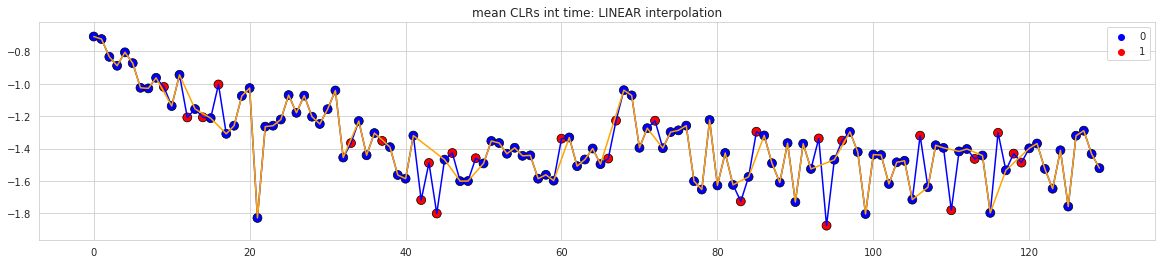

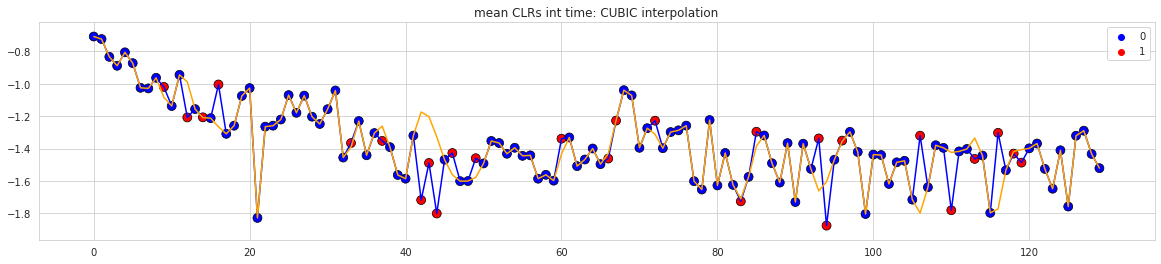

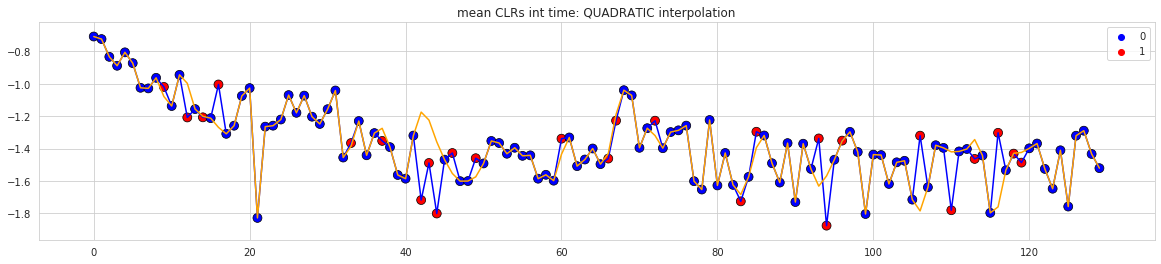

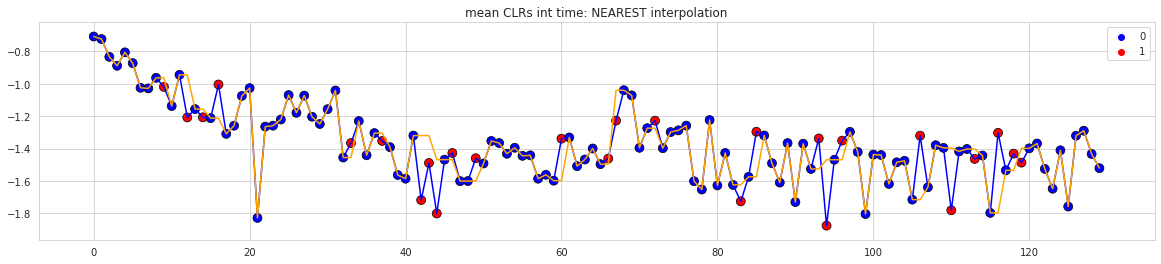

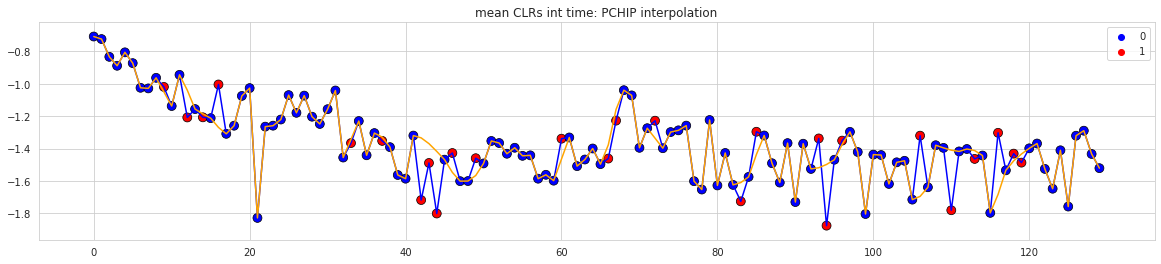

In [ ]:
for df, name in zip(INTERPOLATED_DFS, INTERPOLATION_NAMES):
    plot_lineplot(df, name)